**Purpose:** Extract and plot the TIaaS stats

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc
import requests
import io

In [2]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def get_continent(c):
    '''Extract continent name from a country code'''
    return continents[pc.country_alpha2_to_continent_code(c)]

def get_continents(c):
    '''Extract continent from country codes'''
    if '|' in c:
        cs = c.split('|')
        return ' & '.join(set([get_continent(d) for d in cs]))
    else:
        return get_continent(c)

In [3]:
data_eu = pd.read_csv('https://usegalaxy.eu/tiaas/numbers.csv')
data_eu

,id,start,end,location,use_gtn,attendance
0,249,2019-01-16,2019-01-16,DE,Y,12
1,494,2022-05-09,2022-05-09,DE,Y,20
2,470,2022-02-22,2022-02-25,DE,Y,40
3,454,2021-12-08,2021-12-09,FR,N,22
4,455,2021-12-10,2021-12-10,FR,N,22
...,...,...,...,...,...,...
292,225,2019-09-23,2019-12-11,HU,Y,7
293,210,2019-05-22,2019-05-22,RS,Y,12
294,204,2019-05-13,2019-05-13,GB,N,16
295,189,2019-03-04,2019-03-04,GB,N,30


In [4]:
data_au = pd.read_csv('https://usegalaxy.org.au/tiaas/numbers.csv')
data_au

,id,start,end,location,use_gtn,attendance
0,2,2021-02-09,2021-02-11,AU,Y,30
1,3,2021-02-09,2021-02-15,TD,Y,3
2,4,2021-02-15,2021-02-19,AU|IN|ID,Y,850
3,5,2021-03-26,2021-03-26,AU,N,60
4,6,2021-02-23,2021-02-24,AU,Y,60
5,7,2021-03-23,2021-03-23,AU,N,20
6,9,2021-03-05,2021-03-05,AU,Y,55
7,10,2021-03-18,2021-03-18,AU,N,55
8,11,2021-03-31,2021-03-31,AU,Y,20
9,12,2021-04-21,2021-04-21,AU,Y,35


In [5]:
data_us = (pd.read_csv('https://usegalaxy.org/tiaas/numbers.csv')
           .assign(
               location=lambda x: x['location']
                   .replace("\[Country\(code='","", regex=True)
                   .replace("'\)\]","", regex=True)))
data_us

,name,start,location,use_gtn,attendance
0,gcc2022,2022-07-07,US,Y,80
1,ccf,2022-05-05,US,Y,10
2,montpellier-2022,2022-05-18,FR,N,20


In [6]:
df = (pd.merge(data_eu, data_au, how='outer')
     .merge(data_us, how='outer')
      # transform Y / N to True / False
     .replace("Y", True)
     .replace("N", False)
     .assign(
         start=lambda x: pd.to_datetime(x['start'], format='%Y-%m-%d'),
         end=lambda x: pd.to_datetime(x['end'], format='%Y-%m-%d'),
         month=lambda x: x['start'].dt.to_period('M'),
         year=lambda x: x['start'].dt.to_period('Y'),
         continent=lambda x: [get_continents(y) for y in x['location']]))

df

,id,start,end,location,use_gtn,attendance,name,month,year,continent
0,249.0,2019-01-16,2019-01-16,DE,True,12,NaN,2019-01,2019,Europe
1,494.0,2022-05-09,2022-05-09,DE,True,20,NaN,2022-05,2022,Europe
2,470.0,2022-02-22,2022-02-25,DE,True,40,NaN,2022-02,2022,Europe
3,454.0,2021-12-08,2021-12-09,FR,False,22,NaN,2021-12,2021,Europe
4,455.0,2021-12-10,2021-12-10,FR,False,22,NaN,2021-12,2021,Europe
...,...,...,...,...,...,...,...,...,...,...
343,53.0,2022-07-17,2022-07-20,US,True,80,NaN,2022-07,2022,North America
344,54.0,2022-07-21,2022-07-21,AU,False,25,NaN,2022-07,2022,Australia
345,NaN,2022-07-07,NaT,US,True,80,gcc2022,2022-07,2022,North America
346,NaN,2022-05-05,NaT,US,True,10,ccf,2022-05,2022,North America


# General stats

Stats collected in timeframe

In [7]:
print(f"{min(df['start'])} - {max(df['start'])}")
print(f"Number of TIaaS events: {len(df)}")
print(f"Percentage using GTN: {sum(df.use_gtn)/len(df)*100:0.2f}%")
print(f"Total Participants: {sum(df.attendance)}")

paper_sentence = f"For example, between {min(df['start']).strftime('%B %Y')} and {max(df['end']).strftime('%B %Y')}, Galaxy Europe and Galaxy Australias has been used for more than {round(len(df), -1)} training events reaching more than {round(sum(df.attendance), -1)} students."
with open("../snippets/tiaas.tex", 'w') as handle:
    handle.write(paper_sentence)

2018-06-20 00:00:00 - 2022-09-01 00:00:00
Number of TIaaS events: 348
Percentage using GTN: 64.94%
Total Participants: 17655


# Evolution over the months

In [8]:
nb_per_months_df = (df
    .groupby(df.month)
    .agg({'start': ['count'], 'attendance': ['sum']}))
nb_per_months_df.columns = ['Events', 'Participants']
nb_per_months_df.tail()

,Events,Participants
month,,
2022-05,14,656
2022-06,5,130
2022-07,8,350
2022-08,2,50
2022-09,1,40


Average number of events per months

In [9]:
sum(nb_per_months_df.Events)/len(nb_per_months_df)

6.823529411764706

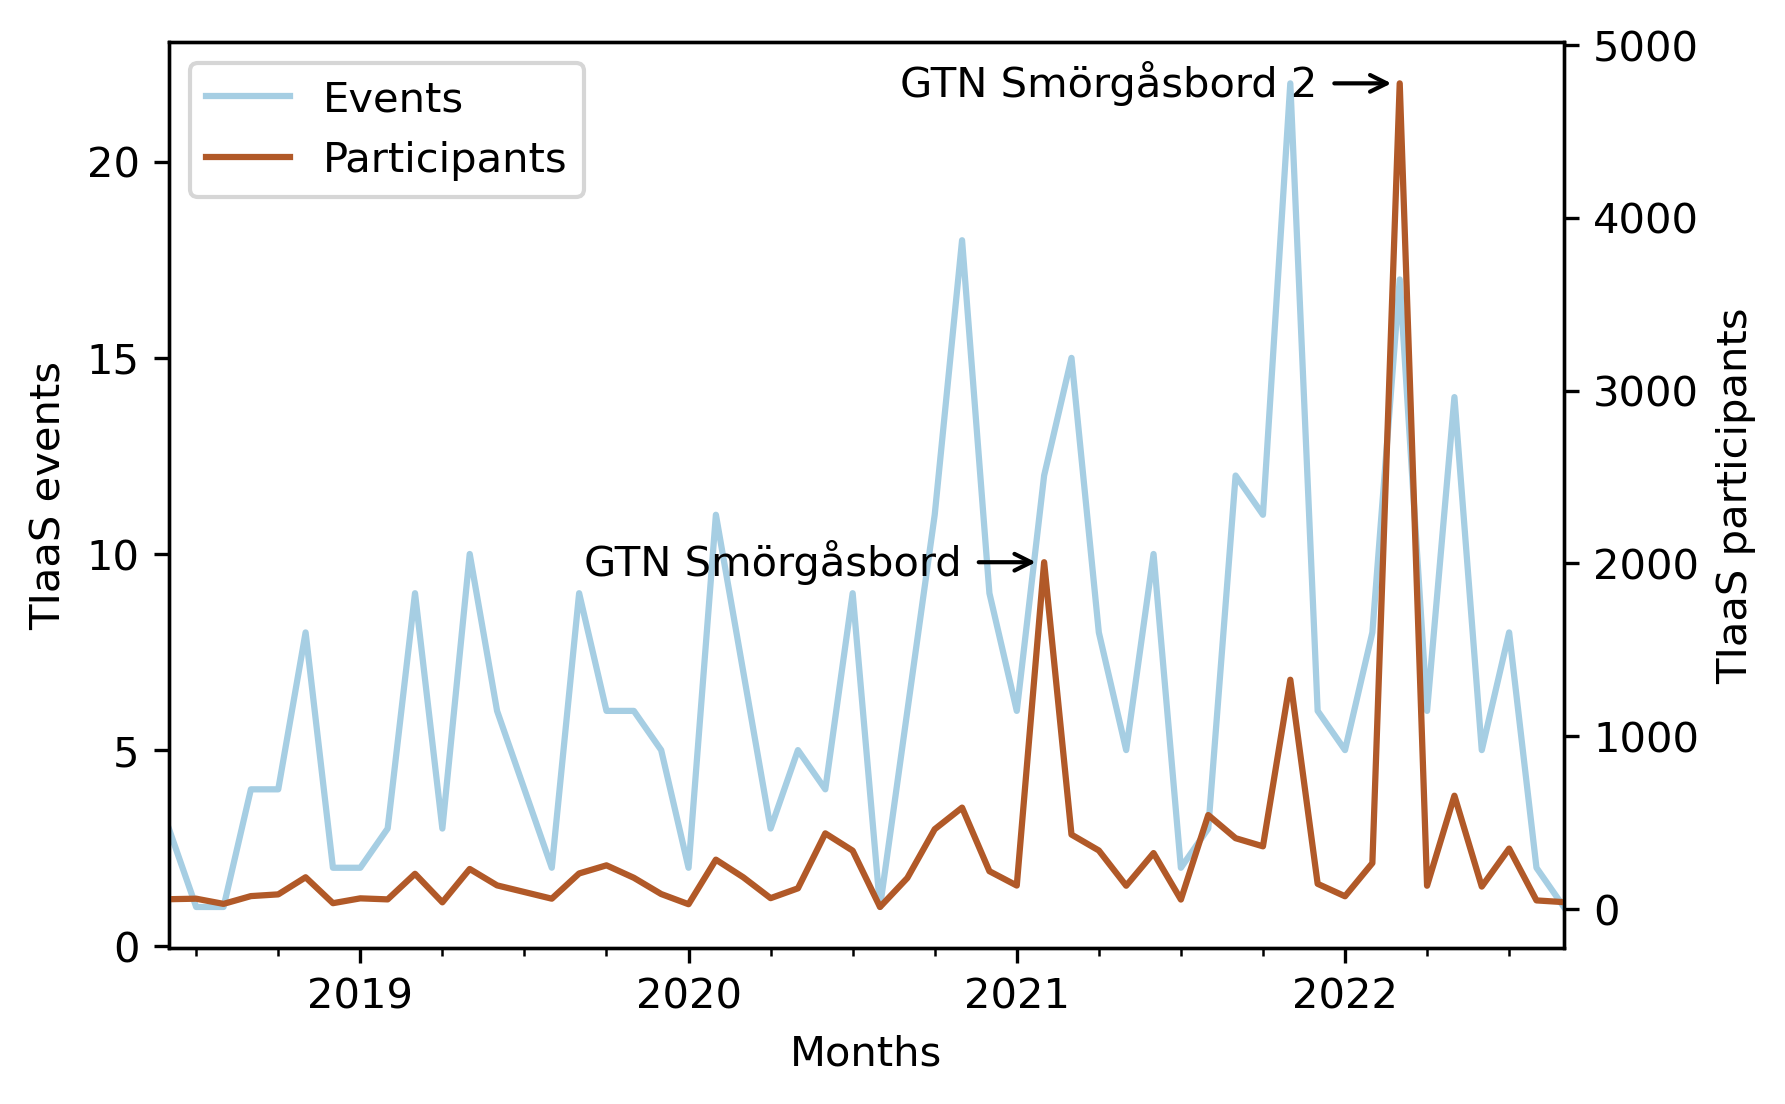

In [10]:
fig, ax = plt.subplots()
fig.set_dpi(300)

(nb_per_months_df
 .plot(colormap='Paired', secondary_y=['Participants'], mark_right=False, ax=ax)
)
ax.set_xlabel('Months')
ax.set_ylabel('TIaaS events')
ax.right_ax.set_ylabel('TIaaS participants')
plt.annotate(
    'GTN Smörgåsbord',
    xy=('2021-02-15', nb_per_months_df['Participants']['2021-02']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['Participants']['2021-02']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'GTN Smörgåsbord 2',
    xy=('2022-03-15', nb_per_months_df['Participants']['2022-03']),
    xycoords='data',
    xytext=('2021-12-01', nb_per_months_df['Participants']['2022-03']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')

plt.savefig('../images/tiaas-events.png', bbox_inches='tight')

# Location

In [11]:
nb_per_continents_df = (df
    .groupby(by='continent')
    .count()
    .filter(['start'])
    .rename(columns = {'start': 'Events'}))
nb_per_continents_df / len(df) * 100

,Events
continent,
Africa,3.160920
Asia,3.160920
Australia,15.804598
Australia & Asia,0.287356
Europe,69.252874
North America,7.758621
South America,0.574713


In [12]:
continent_year_event_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_event_df[c][y] = len(grouped_df.get_group(g))
continent_year_event_df.loc['Total'] = continent_year_event_df.sum(axis=0)
continent_year_event_df['Total'] = continent_year_event_df.sum(axis=1)
continent_year_event_df

,Africa,Asia,Australia,Australia & Asia,Europe,North America,South America,Total
Total,11,11,55,1,241,27,2,348
2022,2,3,16,0,38,7,0,66
2021,3,6,28,1,63,11,0,112
2020,2,2,8,0,69,5,0,86
2019,3,0,2,0,52,3,1,61
2018,1,0,1,0,19,1,1,23


In [13]:
(continent_year_event_df
.drop(['Total'], axis=1)
.drop(['Total'], axis=0))

,Africa,Asia,Australia,Australia & Asia,Europe,North America,South America
2022,2,3,16,0,38,7,0
2021,3,6,28,1,63,11,0
2020,2,2,8,0,69,5,0
2019,3,0,2,0,52,3,1
2018,1,0,1,0,19,1,1


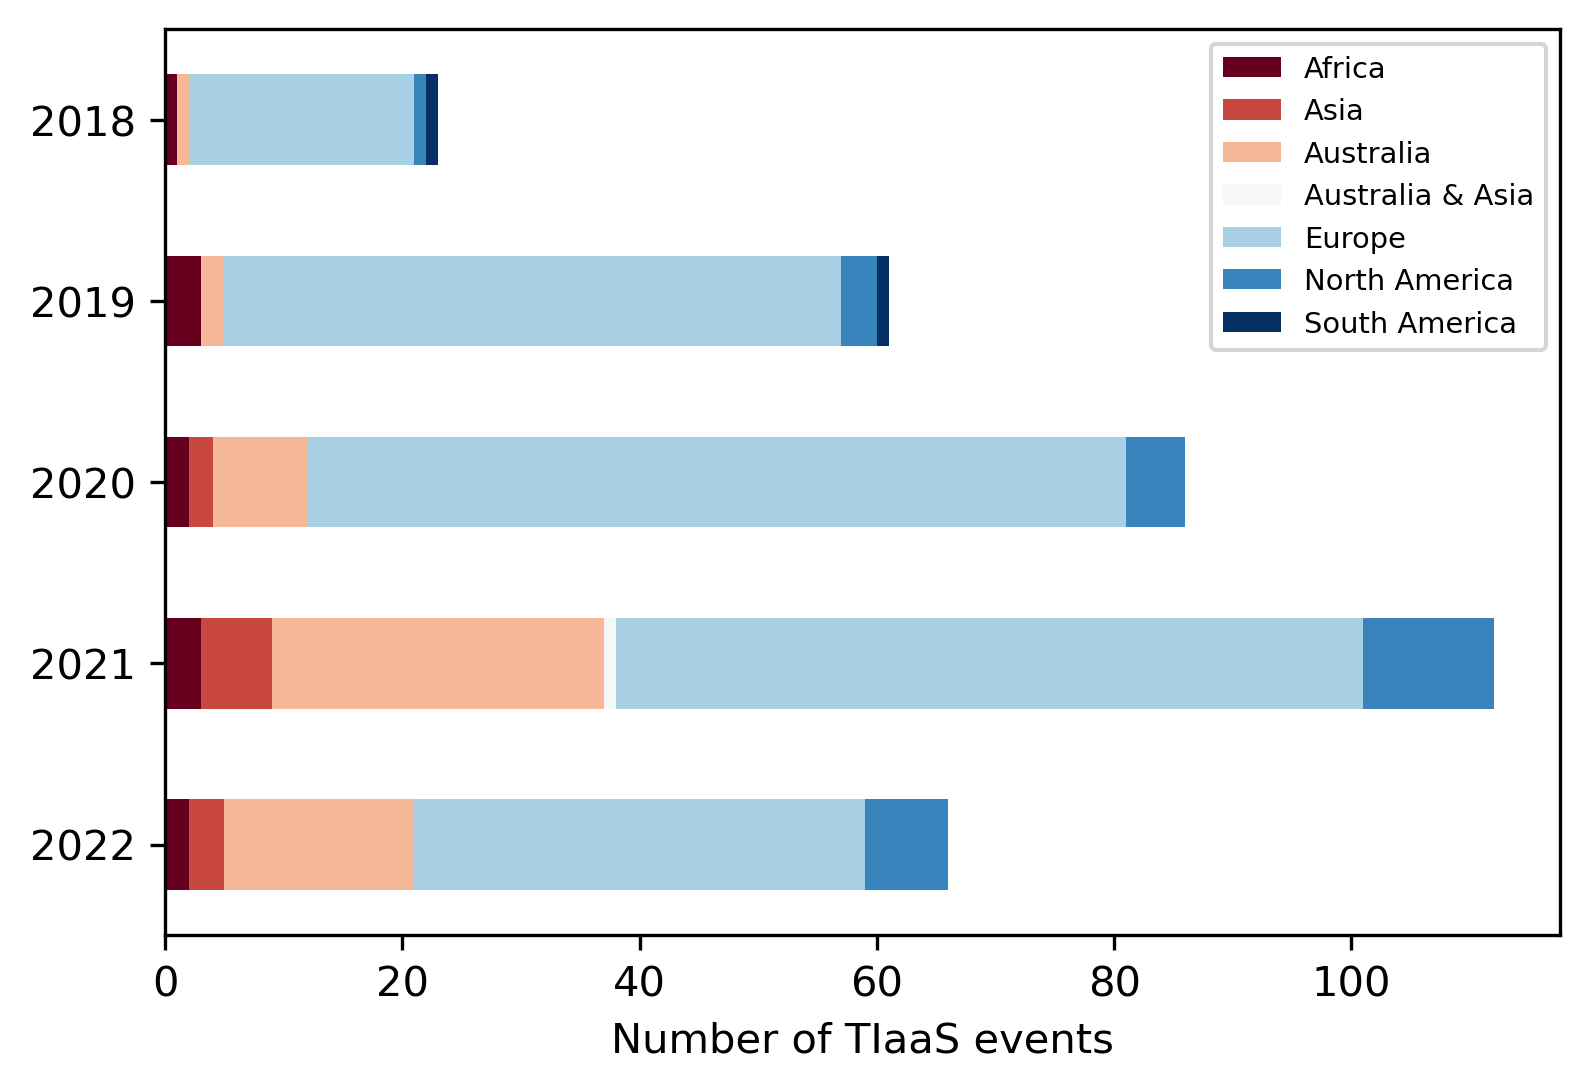

In [14]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_event_df
     .drop(['Total'], axis=1)
     .drop(['Total'], axis=0)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of TIaaS events')
ax.legend(
    #loc='center left',
    #bbox_to_anchor=(1, 0.5),
    #frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-events-per-year.png', bbox_inches='tight')

In [15]:
continent_year_participants_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_participants_df[c][y] = sum(grouped_df.get_group(g).attendance)
continent_year_participants_df.loc['Total'] = continent_year_participants_df.sum(axis=0)
continent_year_participants_df['Total'] = continent_year_participants_df.sum(axis=1)
continent_year_participants_df

,Africa,Asia,Australia,Australia & Asia,Europe,North America,South America,Total
Total,623,503,2255,850,12526,818,80,17655
2022,334,70,840,0,4920,315,0,6479
2021,48,353,1121,850,3604,241,0,6217
2020,124,80,260,0,2271,182,0,2917
2019,101,0,24,0,1332,40,20,1517
2018,16,0,10,0,399,40,60,525


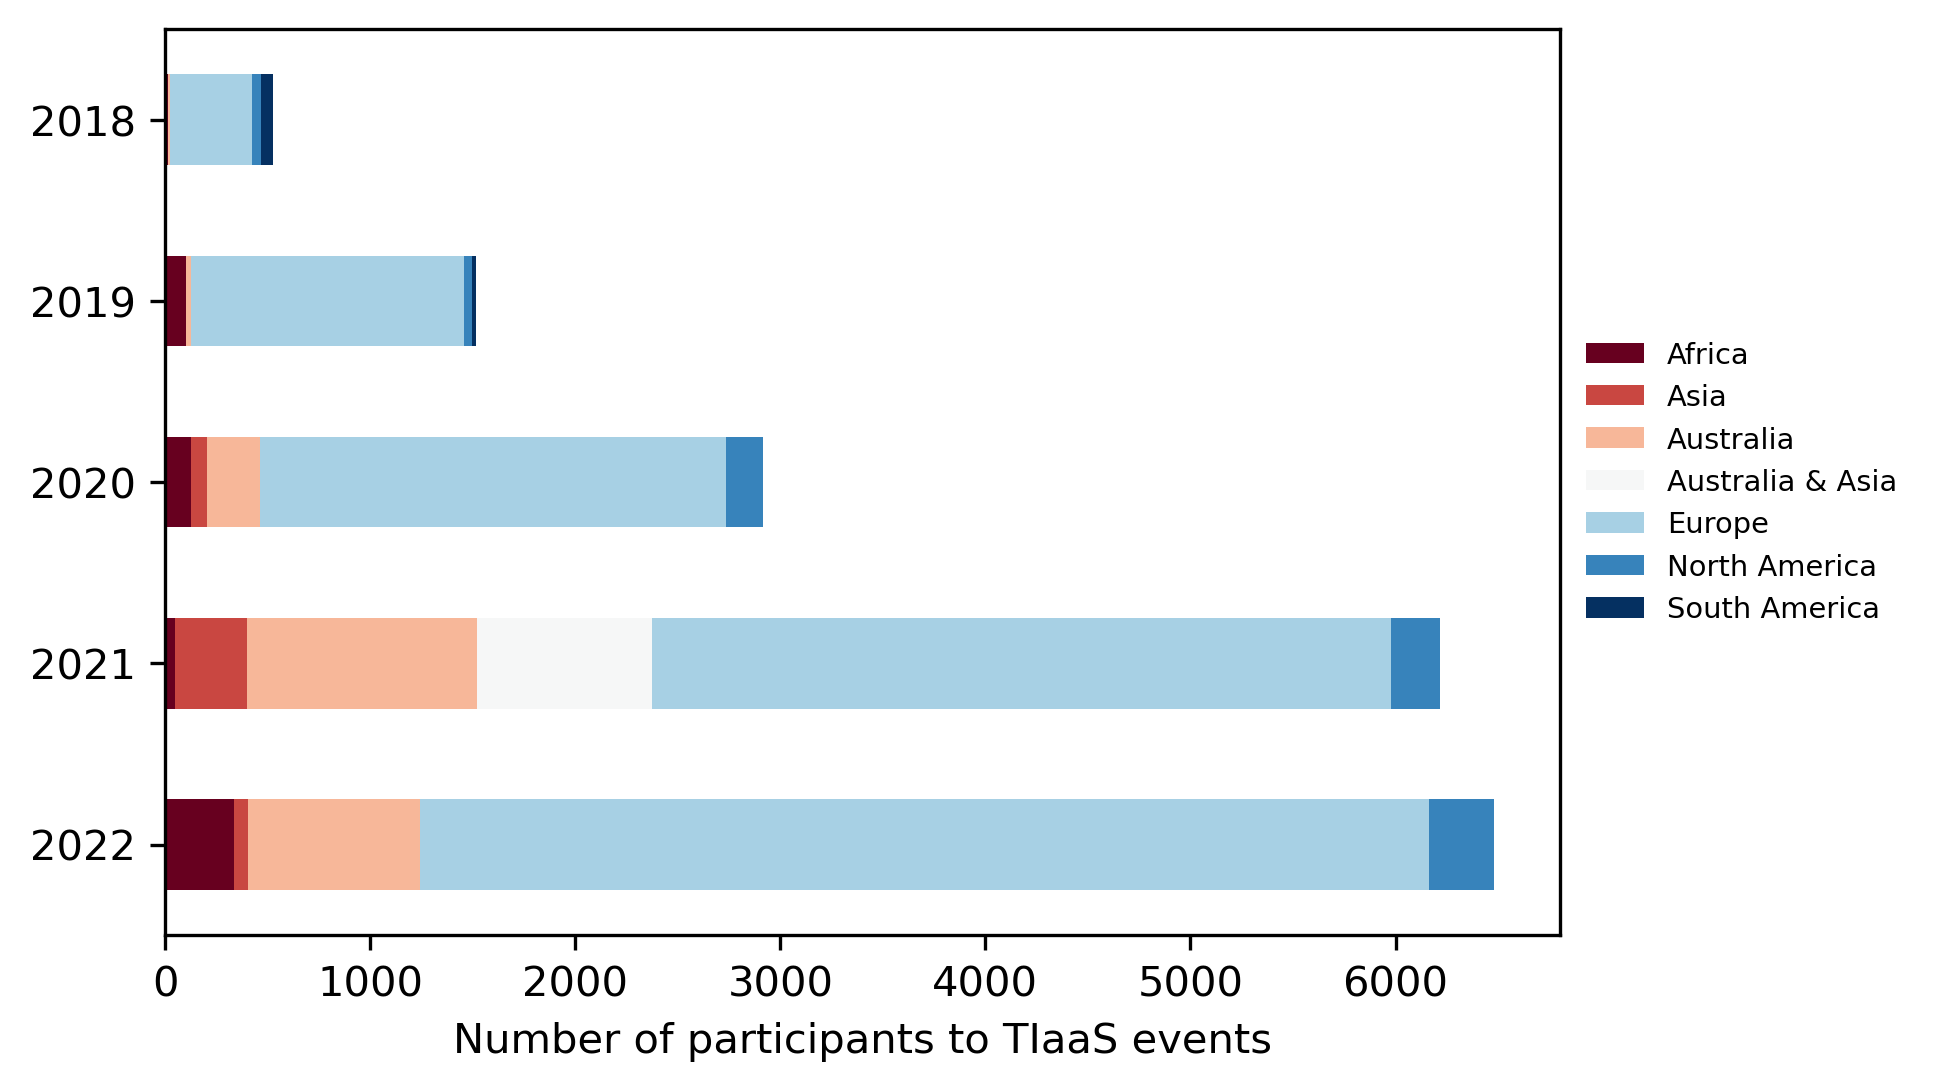

In [16]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_participants_df
     .drop(['Total'], axis=1)
     .drop(['Total'], axis=0)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of participants to TIaaS events')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-participants-per-year.png', bbox_inches='tight')